In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Minmax(object):
    
    '''
    This is a simple MinMax algorithm with score-Hashing and Alpha Beta pruning.
    The score evaluates a heuristic.
    '''
    
    count = 0
    DIC ={}
    
    def __init__(self):
        
        #load a DIC with some precalculated values values
        try: 
            self.DIC = self.load_obj('scores')
        except (RuntimeError, TypeError, NameError, OSError, IOError):
            self.DIC  = {}
            print '--> no scores.pkl available. Now it takes way longer to build the tree!!'

    def save_obj(self, obj, name ):
        import pickle
        '''
        save a data object
        '''
        with open(name + '.pkl', 'wb') as f:
            pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    def load_obj(self, name):
        '''
        loads a data object
        '''
        import pickle
        with open(name + '.pkl', 'rb') as f:
            return pickle.load(f)
    
    def get_hash_key(self, board):
        '''
        This function creates a hashkey for a board so it can be stored in the dictionary.
        '''
        b=np.ndarray.flatten(board)
        string_flat=np.char.mod('%d', b)
        key = "".join(string_flat)
        return key
    
    
    #heuristic to evaluate the next best move
    def score(self, state, depth, cur_player):
        '''
        heuristic function that uses Hashing for the scores if they are already calculated
        
        state: current gameState
        depth: current depth
        cur_player: current player
        
        we are using a simple heuristic here,
        just counting and punishing good and reward good moves with a weight.
        
        score = num of(four in row)*1000+ num of(three in row)* 100+ num of(two in row)*10
        - num of opponent(four in row)*100000- num of opponent(three in row)*100- 
        num of opponent(two in row)*10
                
        returns the score
        '''
        
        if cur_player == 1:
            oponent = 2
        else:
            oponent = 1
            
        hash_key = self.get_hash_key(state)
        
        # Score already calculated
        if hash_key in self.DIC:
            return self.DIC[hash_key]
        
        # else calculate
        else:
                
            #counting the number of good four/threes/twos in a row/column/diag
            _ , b = zip(*(move_was_winning_move(state, cur_player, e) for e in range(2,5)))
            _ , c = zip(*(move_was_winning_move(state, oponent, f) for f in range(2,5)))
            

            score = b[2]*1000+b[1]*100+b[0]*10-c[2]*100000-c[1]*100-c[0]*10
            
            #and put in DIC
            self.DIC[hash_key]  = score
            return score
    
    def listofmoves(self, gameState):
        '''
        returns a list of possible moves = column not full and orders it with middle first
        
        gameState: current gamestate
        
        return: list of possible moves
        '''
        l=[]
        for i in range(gameState.shape[1]):
            if 0 in gameState[:,i]:
                l.append(i)
        
        m=sum(l)/len(l)
        return sorted(l, key=lambda x:abs(x-m))

    
    def min_play(self, board, depth, alpha ,beta , cur_player):
        '''
        recursively building a the tree, min part of minmax
        minimzing the score, moving the oponent
        
        board: a gameState 
        depth: depth parameter of search tree
        cur_player: the current_player's number
        
        return best score
        '''
        self.count = self.count+1

        #eval current player
        if cur_player == 1:
            oponent = 2
        else:
            oponent = 1
            
        #termination
        #max depth
        if depth == 0:
            return self.score(board, depth, cur_player)
        #all full
        if not move_still_possible(board):
            return self.score(board, depth, cur_player)
        #or winner
        
        winningmove, _ = move_was_winning_move(board, cur_player, 4)
        if winningmove:
            return self.score(board, depth, cur_player)
        

        
        best_score = np.inf
        
        #get all available moves
        moves = self.listofmoves(board)
        best_move = moves[0]
        
        if len(moves) == 0:
            return self.score(board, depth, cur_player)
        
        for eachmove in moves:
            #copy board and move oponent
            boardcopy = board.copy()
            
            board_i, _ , _ = move(boardcopy, oponent, eachmove)
            
            #build recursivley max
            score = self.max_play(board_i, depth-1,alpha ,beta , cur_player)
                        
            #compare scores MIN
            #if score < best_score:
            #    best_move = eachmove
            #    best_score = score
                #print 'if', best_move, best_score
                
            #with alpha - beta
            if score < beta:
                beta = score
                #best_move = eachmove
            if beta <= alpha:
                return beta

        
        return beta#, best_move
    
    
    def max_play(self, board, depth, alpha ,beta , cur_player):
        '''
        recursively building a the tree, max part of minmax
        maximizing the score
        
        board: a gameState 
        depth: depth parameter of search tree
        cur_player: the current_player's number
        
        return best score
        '''
        self.count = self.count+1

        #eval current player
        if cur_player == 1:
            oponent = 2
        else:
            oponent = 1
            
        #termination
        #max depth
        if depth == 0:
            return self.score(board, depth, cur_player)
        #all full
        elif not move_still_possible(board):
            return self.score(board, depth, cur_player)
        #or winner
        winningmove, _ = move_was_winning_move(board, cur_player, 4)
        if winningmove:
            return self.score(board, depth, cur_player)
                
        
        best_score = -np.inf
        
        #get all available moves
        moves = self.listofmoves(board)
        best_move = moves[0]
        
        if len(moves) == 0:
            return self.score(board, depth, cur_player)
        
        for eachmove in moves:

            #copy board and move player
            boardcopy = board.copy()
            
            board_i, _ , _ = move(boardcopy, cur_player, eachmove)
            
            #build recursivley min
            score = self.min_play(board_i, depth-1,alpha ,beta , cur_player)
                        
            #compare scores MAX
            #if score > best_score:
            #    best_move = eachmove
            #    best_score = score
                #print 'if', best_move, best_score
            
            #with alpha-beta
            if score > alpha:
                alpha = score
                #best_move = eachmove
            if alpha >= beta:
                return alpha
        
        return alpha #, best_move
    
    
    def minmax(self, board, cur_player, depth=4, alpha=-np.inf, beta=np.inf):
        '''
        recursively building a the tree with alpha beta pruning
        may not be the best choice but everyone keeps saying: memory is cheap
        
        board: a gameState 
        depth: depth parameter of search tree
        cur_player: the current_player's number
        
        return best score, best move
        '''
        self.count = self.count+1
        
        #eval current player
        if cur_player == 1:
            oponent = 2
        else:
            oponent = 1
        
        best_score = -np.inf
        
        #get all available moves
        moves = self.listofmoves(board)
        best_move = moves[0]

        #for each move do
        for eachmove in moves:
            #print eachmove
            #copy board and move
            boardcopy = board.copy()               
                
            #build recursivley
            board_i, _ , _ = move(boardcopy, cur_player, eachmove)
            
            score = self.min_play(board_i, depth-1 ,alpha ,beta,  cur_player)
                        
            #compare scores
            if score > alpha:
                alpha = score
                best_move = eachmove
            if alpha >= beta:
                return alpha
        
        return alpha, best_move

In [3]:
#import numpy as np


def move_is_correct(grid,num):
    '''
    @param grid: 6x7 grid containing the current game state
    @param num: column

    returns True if move is allowed on that column
    '''

    #if 0 is in column
    if 0 in grid[:,num]:
    
        #move is allowed
        return True

    else:

        return False

def move_still_possible(S):
    '''
    @param S: 6x7 grid containing the current game state
    returns True if grid contains no 0, therefore no move possible anymore
    '''
    return not(S[S==0].size == 0)


def move(S,p,col_num):
    '''
    @param S: 6x7 grid containing the current game state
    @param p: current player
    @param col_num: column number
    
    sets the player's number on the grid and returns the grid
    '''
    
    #sanity check
    if 0 in S[:,col_num]:    
        y = np.where(S[:,col_num]==0)[0][-1]
        S[y,col_num] = p
        return S , y, col_num
    else:
        return S, None, None
        return 

def move_at_random(S):
    '''
    @param S: 6x7 grid containing the current game state
    moves at random
    '''
    return np.random.randint(0,S.shape[1])


#neat and ugly but the fastest way to search a matrix for a vector is a string find
player1=[' ','1', '1 1', '1 1 1', '1 1 1 1']
oponent=[' ','1', '2 2', '2 2 2', '2 2 2 2']


def move_was_winning_move(S, p, num):
    '''
    @param S: 6x7 grid containing the current game state
    @param p: current player
    @param num: how many occurences to count
    
    combines all the allowed formations of the grid and string_finds with 
    the currents player vector. Returns true if match.
    
    return: True or False whether move was winning move or not,
            and count of occurences
    '''
    if p == 1:
        match = player1[num]
    else:
        match = oponent[num]

    l=[]
    #for every possible diag
    for i in range(-2,4):
        l.append(np.diag(S,k = i))
        l.append(np.diag(np.fliplr(S),k=i))
    #left to right
    l.append(S)
    #top to bottom
    l.append(np.rot90(S)) 
    
    #convert to string
    stringmatrix =''.join(np.array_str(e) for e in l)
    
    #count the occurences
    counter = stringmatrix.count(match)
    
    #print stringmatrix
    
    #if four in a row
    if num == 4 and counter == 1:
        return True, counter
    return False, counter





# relate numbers (1, -1, 0) to symbols ('x', 'o', ' ')
symbols = {1:'m', 2:'r', 0:' '}

# print game state matrix using symbols
def print_game_state(S):
    B = np.copy(S).astype(object)
    for n in [1, 2, 0]:
        B[B==n] = symbols[n]
    print B





if __name__ == '__main__':
    # initialize 6x7 connectfour board
        # initialize array that counts how often a cell contributed to a win
    final = np.zeros((6,7), dtype = float)  
    outcomes = []
    mvcntrlist = []
    nodeslist = []
    
    print 'This is a Minmax vs Random Connect Four simulation: '
    difficulty = int(raw_input('Difficulty: '))
    
    for i in range(10):
        
        gameState = np.zeros((6,7), dtype=int)

        # initialize player number, move counter
        player = 1
        mvcntr = 1

        # initialize flag that indicates win
        noWinnerYet = True

        m = Minmax()
        size = len(m.DIC)


        while move_still_possible(gameState) and noWinnerYet:

            while True:
                # get player symbol
                name = symbols[player]
                #print '%s moves' % name

                # move with Minmax
                if player == 1:
                    _ , col_num = m.minmax(gameState, 1, difficulty, -np.inf, np.inf)
                
                # let player move at random
                else:
                    col_num = move_at_random(gameState)

                if move_is_correct(gameState, col_num):
                    gameState, _ , _ = move(gameState,player,col_num)

                    # print current game state
                    #print_game_state(gameState)

                    # evaluate game state
                    winningmove, _ = move_was_winning_move(gameState, player, 4)
                    if winningmove:
                        
                        # determine who won
                        winner = player
                        
                        # get the positions of the fields the winner selected
                        xp, yp = np.where(gameState == winner)
                        
                        # update "final" which counts how often a cell contributed
                        # to a win
                        final[xp,yp] +=1
                        #for i in range(0, len(xp)):
                        #    final[xp[i], yp[i]] += 1
                
                        noWinnerYet = False
                        
                        #add to list which winner
                        outcomes.append(player)
                        #how many moves
                        mvcntrlist.append(mvcntr)
                        #how many nodes
                        nodeslist.append(m.count)

                    # switch player and increase move counter
                    if player == 1:
                        player = 2
                    elif player == 2:
                        player = 1

                    mvcntr +=  1

                    break




        if noWinnerYet:
            outcomes.append(0)

            #save new DIC to increase
        if size < len(m.DIC):
            m.save_obj(m.DIC,'scores')
        
            #print 'game ended in a draw' 
        print i

    print 'length of DIC:',len(m.DIC)
    print 'number of nodes:', m.count
    print 'Finished'
    
    # normalize the count data and store it on disk
    normed_final = final / np.sum(final, dtype=np.float)
    print normed_final
    np.savetxt("normed_count.csv", normed_final, delimiter=",")

This is a Minmax vs Random Connect Four simulation: 
Difficulty: 3
0
1
2
3
4
5
6
7
8
9
length of DIC: 224473
number of nodes: 678
Finished
[[ 0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.02325581  0.          0.          0.          0.        ]
 [ 0.          0.          0.02325581  0.          0.          0.          0.        ]
 [ 0.          0.          0.02325581  0.02325581  0.          0.          0.        ]
 [ 0.02325581  0.1627907   0.23255814  0.23255814  0.18604651  0.06976744
   0.        ]]


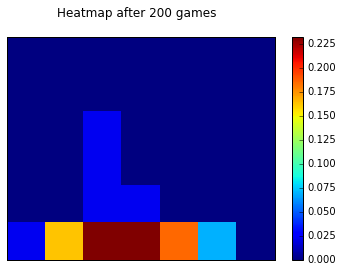

In [4]:
data = normed_final
fig, ax = plt.subplots()
heatmap = ax.pcolor(data)
cbar = plt.colorbar(heatmap)
ax.set_xticks([])
ax.set_yticks([])

ax.invert_yaxis()

plt.title('Heatmap after 200 games  \n')
plt.show()

## Tournament Minmax vs Random

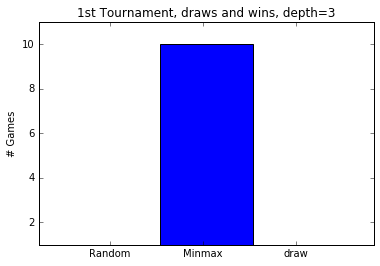

In [6]:
his = plt.hist(outcomes,bins=3)
offset = -.18
plt.title("1st Tournament, draws and wins, depth="+str(difficulty))
#plt.xlabel("left: o wins, middle: draw, right: x wins")
plt.ylabel("# Games") 
axes = plt.gca()
axes.set_ylim([1,len(outcomes)+1]) # y axis should include all 2000 games
#axes.set_xlim([0,0])
axes.set_xticks(his[1][1:]+offset)
axes.set_xticklabels( ('Random', 'Minmax', 'draw') )   

In [7]:
outcomes.count(0), outcomes.count(1), outcomes.count(2)

(0, 10, 0)

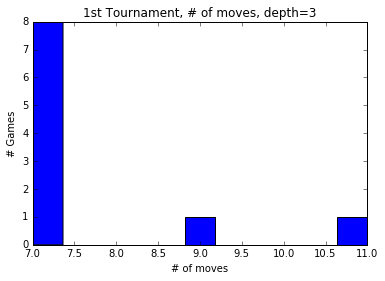

In [8]:
his = plt.hist(mvcntrlist,bins=max(mvcntrlist))
plt.title("1st Tournament, # of moves, depth="+str(difficulty))
#plt.xlabel("left: o wins, middle: draw, right: x wins")
plt.ylabel("# Games")
plt.xlabel('# of moves')
axes = plt.gca()

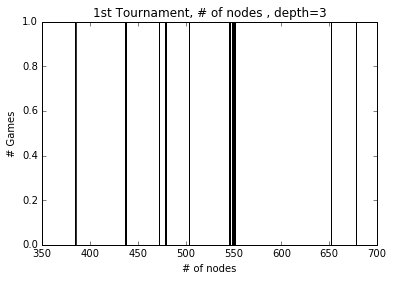

In [9]:
his = plt.hist(nodeslist,bins=max(nodeslist))
plt.title("1st Tournament, # of nodes , depth="+str(difficulty))
#plt.xlabel("left: o wins, middle: draw, right: x wins")
plt.ylabel("# Games")
plt.xlabel('# of nodes')
axes = plt.gca()

# cProfile
with command:  python -m cProfile -s cumtime connectfour-withMinmax.py

#### Depth 2: 

11008374 function calls (10559783 primitive calls) in 14.654 seconds

10845027 function calls (10398214 primitive calls) in 12.555 seconds

8587527 function calls (8188635 primitive calls) in 7.127 seconds

#### Depth 3:

3336653 function calls (3330229 primitive calls) in 4.693 seconds

10010685 function calls (9583101 primitive calls) in 9.372 seconds

#### Depth 4:

19532712 function calls (18898637 primitive calls) in 24.994 seconds

#### Depth 5
69043885 function calls (67314936 primitive calls) in 118.056 seconds


### Time the Building of a minmax tree
with a timer method

In [14]:
import time
def timing(f):
    def wrap(*args):
        time1 = time.time()
        ret = f(*args)
        time2 = time.time()
        print '%s function took %0.3f ms' % (f.func_name, (time2-time1)*1000.0)
        return ret
    return wrap

In [15]:
testgame=np.array([[0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0]])

In [21]:
m = Minmax()
@timing
def do_work(dif):
    return m.minmax(testgame, 1, dif, -np.inf, np.inf)

In [25]:
for i in range(1,7):
    do_work(i)

do_work function took 1.235 ms
do_work function took 34.304 ms
do_work function took 94.698 ms
do_work function took 288.690 ms
do_work function took 2281.134 ms
do_work function took 3482.528 ms


In [33]:
t=[0,1.235,34.304,94.698,288.690,2281.134,3482.528]

(1, 7)

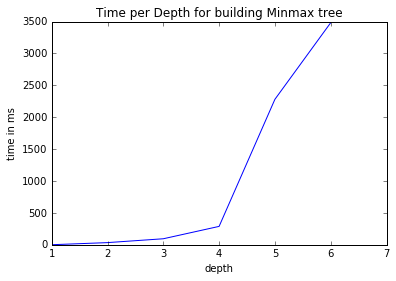

In [37]:
plt.plot(t)
plt.title('Time per Depth for building Minmax tree')
plt.xlabel('depth')
plt.ylabel('time in ms')
plt.xlim(1,7)